In [ ]:
# Linux command
# %%bash
# wget "https://pjreddie.com/media/files/yolov3.weights"

--2024-06-22 07:04:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

     0K .......... .......... .......... .......... ..........  0%  769K 5m15s
    50K .......... .......... .......... .......... ..........  0%  763K 5m16s
   100K .......... .......... .......... .......... ..........  0% 4.86M 3m47s
   150K .......... .......... .......... .......... ..........  0%  900K 3m57s
   200K .......... .......... .......... .......... ..........  0% 41.3M 3m11s
   250K .......... .......... .......... .......... ..........  0% 53.9M 2m40s
   300K .......... .......... .......... .......... ..........  0% 1.78M 2m36s
   350K .......... .......... .......... .......... ..........  0% 1.37M 2m38s
   400K .......... .......... .......

In [ ]:
# %%bash
# wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"

--2024-06-22 07:04:41--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg.1’

     0K ........                                              100% 20.2M=0s

2024-06-22 07:04:41 (20.2 MB/s) - ‘yolov3.cfg.1’ saved [8342/8342]



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
CONFIDENCE = 0.6
SCORE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.6

# the neural network config
config_path = 'yolov3.cfg'

# the YOLO net weights file
weights_path = 'yolov3.weights'

# weights_path = "weights/yolov3-tiny.weights"

#loading all class labels [objects]
labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [ ]:
# generating colors for each object for later plotting
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')
colors.shape

(80, 3)

In [ ]:
#load YOLO network
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
type(net)

cv2.dnn.Net

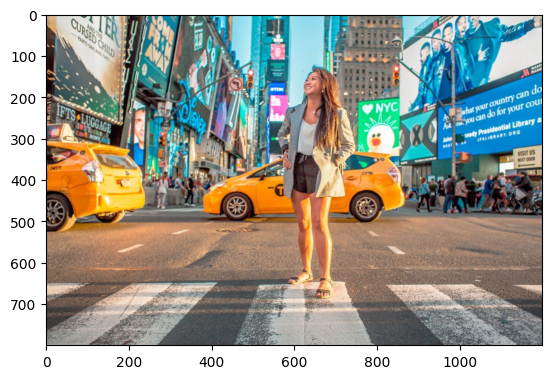

In [ ]:
import os
image = cv2.imread('NYC.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
file_name = os.path.basename('NYC.jpg')
filename, ext = file_name.split('.')

plt.imshow(image);

In [ ]:
h, w = image.shape[:2]
# create 4D blob

blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
# blob

In [ ]:
blob.shape

(1, 3, 416, 416)

In [ ]:
ln = net.getLayerNames()
# ln

In [ ]:
net.getUnconnectedOutLayers()

array([200, 227, 254], dtype=int32)

In [ ]:
# sets the blob as input of  network
net.setInput(blob)

# get all layer names
ln = net.getLayerNames()
try:
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
  # In case getUnconnectedOutLayers() returns 1D array when cuda isn't available
  ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

# Feedforword (Inference) get network outputs
layer_outputs = net.forward(ln)

# layer_outputs

In [ ]:
layer_outputsfont_scale = 0.7
thickness = 2
boxes, confidences, class_ids = [], [], []

# Loop over each of the layer outputs
for ouput in layer_outputs:
  # Loop over each of the object detections

  for detection in ouput:
    # Extract the class ID (label) and confidence (i.e., probability) of the current object detection

    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]

    # Filter out weak predictions by ensuring the detected probability is greater than the minimum probability

    if confidence > CONFIDENCE:

      # Scale the bounding box coordinates back relative to the size of the image,
      # keeping in mind that YOLO actually returns the center (x,y)
      # coordinates of the bounding box followed by the boxes' width and height.

      box = detection[0:4] * np.array([w, h, w, h])
      (centerX, centerY, width, height) = box.astype("int")

      # Use the center (x, y)-coordinates to derive the top and left corner of the bounding box.
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      # Update the list of bounding box cordinates, confidences, and class IDs
      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      class_ids.append(class_id)


In [ ]:
# boxes, confidences

In [ ]:
class_ids

[2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
labels[24]

'backpack'

In [ ]:
# # loop over the indexes we are keeping
# for i in range(len(boxes)):
#   # Extract the bounding box coordinates
#   x, y = boxes[i][0], boxes[i][1]
#   w, h = boxes[i][2], boxes[i][3]

#   # Draw a bounding box rectangle and label on the image
#   color = [int(c) for c in colors[class_ids[i]]]
#   cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=2)
#   text = "f {labels[class_ids[i]]}:  {confidences[i]:.2f}"

#   #calculate text width and height to draw transparet boxes as background of the text
#   (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.4, thickness=1)[0]
#   text_offset_x = x
#   text_offset_y = y - 5
#   box_cords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
#   overlay = image.copy()
#   cv2.rectangle(overlay, box_cords[0], box_cords[1], color=color, thickness = cv2.FILLED)

#   #add opacity(transparency) to box
#   image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)

#   #now put the text (label: confidence %)
#   cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4, color=(0, 0, 0), thickness=1)

In [ ]:
# plt.imshow(image);

In [ ]:
indexes=cv2.dnn.NMSBoxes(boxes, confidences, 0.5,0.4)
indexes

array([12, 14, 15,  1,  6,  4, 17,  8, 13, 10, 18,  9, 16,  7],
      dtype=int32)

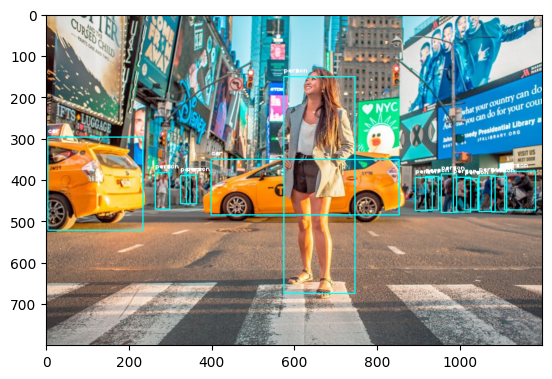

In [ ]:
for i in range(len(boxes)):
  if i in indexes:
    x,y,w,h = boxes[i]
    label = str(labels[class_ids[i]])
    color = colors[class_ids[i]]
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,255), 2)
    cv2.putText(image, label, (x,y-10), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)

plt.imshow(image);